Historical Data Shape: (211224, 16)
Fear/Greed Data Shape: (2644, 4)

Sample of aggregated trader data:
                                      Account        date  trade_count  \
0  0x083384f897ee0f19899168e3b1bec365f52a9012  1970-01-01         3818   
1  0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd  1970-01-01         7280   
2  0x271b280974205ca63b716753467d5a371de622ab  1970-01-01         3809   
3  0x28736f43f1e871e6aa8b1148d38d4994275d72c4  1970-01-01        13311   
4  0x2c229d22b100a7beb69122eed721cee9b24011dd  1970-01-01         3239   

      total_pnl     avg_pnl  win_rate  avg_leverage  median_size  
0  1.600230e+06  419.127768  0.359612           0.0     1348.160  
1  4.788532e+04    6.577654  0.442720           0.0      462.815  
2 -7.043619e+04  -18.492043  0.301917           0.0     1116.380  
3  1.324648e+05    9.951530  0.438585           0.0      148.310  
4  1.686580e+05   52.071011  0.519914           0.0      958.550  

Missing values in feature columns after imputati

/tmp/ipython-input-2938501392.py:64: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged['value'] = merged['value'].fillna(method='ffill')
/tmp/ipython-input-2938501392.py:65: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged['classification'] = merged['classification'].fillna(method='ffill')
/tmp/ipython-input-2938501392.py:65: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged['classification'] = merged['classification'].fillna(method='ffill')
/usr/local/lib/python3.12/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.90      1.00      0.95         9

    accuracy                           0.90        10
   macro avg       0.45      0.50      0.47        10
weighted avg       0.81      0.90      0.85        10

ROC-AUC Score: 1.0


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


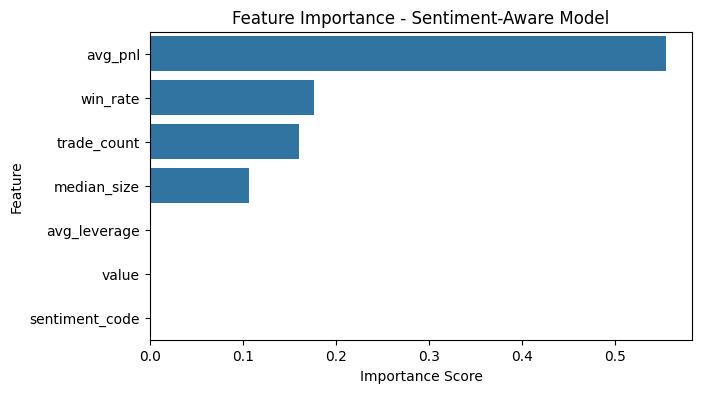


 Analysis complete! Files saved to:
- /content/merged_sentiment_trader_data.csv
- /content/feature_importances.csv


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score


hist = pd.read_csv("/content/drive/MyDrive/historical_data.csv")
sent = pd.read_csv("/content/drive/MyDrive/fear_greed_index.csv")

print("Historical Data Shape:", hist.shape)
print("Fear/Greed Data Shape:", sent.shape)


for col in ['Timestamp', 'Timestamp IST']:
    if col in hist.columns:
        hist[col] = pd.to_datetime(hist[col], errors='coerce')

if 'date' in sent.columns:
    sent['date'] = pd.to_datetime(sent['date'], errors='coerce').dt.date
elif 'timestamp' in sent.columns:
    sent['date'] = pd.to_datetime(sent['timestamp'], errors='coerce').dt.date


hist['datetime'] = hist[['Timestamp', 'Timestamp IST']].bfill(axis=1).iloc[:, 0]
hist['date'] = hist['datetime'].dt.date


hist['Closed PnL'] = pd.to_numeric(hist['Closed PnL'], errors='coerce').fillna(0)
if 'Leverage' not in hist.columns:
    hist['Leverage'] = np.nan
hist['Leverage'] = pd.to_numeric(hist['Leverage'], errors='coerce')


numeric_cols = ['Closed PnL', 'Leverage', 'Size USD']
for col in numeric_cols:
    if col not in hist.columns:
        hist[col] = 0
    hist[col] = pd.to_numeric(hist[col], errors='coerce').fillna(0)
acct_day = (
    hist.groupby(['Account', 'date'])
    .agg(
        trade_count=('Closed PnL', 'count'),
        total_pnl=('Closed PnL', 'sum'),
        avg_pnl=('Closed PnL', 'mean'),
        win_rate=('Closed PnL', lambda x: (x > 0).mean()),
        avg_leverage=('Leverage', 'mean'),
        median_size=('Size USD', 'median')
    )
    .reset_index()
)

print("\nSample of aggregated trader data:")
print(acct_day.head())


sent = sent[['date', 'value', 'classification']].drop_duplicates(subset=['date'])
merged = acct_day.merge(sent, on='date', how='left')


merged['value'] = merged['value'].fillna(method='ffill')
merged['classification'] = merged['classification'].fillna(method='ffill')


merged['sentiment_code'] = merged['classification'].map({
    'Extreme Fear': 0,
    'Fear': 1,
    'Neutral': 2,
    'Greed': 3,
    'Extreme Greed': 4
}).fillna(2)


features = ['trade_count', 'avg_pnl', 'win_rate', 'avg_leverage', 'median_size', 'value', 'sentiment_code']


for col in features:
    if merged[col].isnull().any():
        if merged[col].dtype in ['float64', 'int64']:

            merged[col] = merged[col].fillna(merged[col].mean())
        else:

            merged[col] = merged[col].fillna(method='ffill')

print("\nMissing values in feature columns after imputation:")
print(merged[features].isnull().sum())



if 'classification' in merged.columns and merged['classification'].notna().any():
    plt.figure(figsize=(8,5))
    sns.barplot(x='classification', y='total_pnl', data=merged, estimator=np.mean, ci=None)
    plt.title("Average Trader PnL by Market Sentiment")
    plt.xlabel("Market Sentiment")
    plt.ylabel("Average Total PnL")
    plt.xticks(rotation=15)
    plt.show()
else:
    print("\n'classification' column is empty or contains only missing values after imputation. Skipping PnL vs Sentiment plot.")



merged['profitable'] = (merged['total_pnl'] > 0).astype(int)

merged.dropna(subset=['profitable'], inplace=True)


print("\nFeature DataFrame shape:", merged[features].shape)
print("Target balance:\n", merged['profitable'].value_counts())

X = merged[features]
y = merged['profitable']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))

try:
    print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))
except ValueError:
    print("ROC-AUC Score: Cannot be computed (only one class present in test set)")


importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)
plt.figure(figsize=(7,4))
sns.barplot(x=importances, y=importances.index)
plt.title("Feature Importance - Sentiment-Aware Model")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


merged.to_csv("/content/merged_sentiment_trader_data.csv", index=False)
importances.to_csv("/content/feature_importances.csv")

print("\n Analysis complete! Files saved to:")
print("- /content/merged_sentiment_trader_data.csv")
print("- /content/feature_importances.csv")

In [11]:
import pandas as pd
import os

if 'merged' not in locals() and not os.path.exists('/content/merged_sentiment_trader_data.csv'):
    print("Error: 'merged' DataFrame not found and CSV file does not exist.")
elif 'merged' not in locals():
    print("Loading 'merged' DataFrame from CSV.")
    merged = pd.read_csv('/content/merged_sentiment_trader_data.csv')
    print("DataFrame loaded successfully.")
else:
    print("'merged' DataFrame is already available.")

if 'merged' in locals():
    print("\n'merged' DataFrame head:")
    display(merged.head())
    print("\n'merged' DataFrame columns and types:")
    display(merged.info())

'merged' DataFrame is already available.

'merged' DataFrame head:


,Account,date,trade_count,total_pnl,avg_pnl,win_rate,avg_leverage,median_size,value,classification,sentiment_code,profitable
0,0x083384f897ee0f19899168e3b1bec365f52a9012,1970-01-01,3818,1.600230e+06,419.127768,0.359612,0.0,1348.160,NaN,NaN,2.0,1
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,1970-01-01,7280,4.788532e+04,6.577654,0.442720,0.0,462.815,NaN,NaN,2.0,1
2,0x271b280974205ca63b716753467d5a371de622ab,1970-01-01,3809,-7.043619e+04,-18.492043,0.301917,0.0,1116.380,NaN,NaN,2.0,0
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,1970-01-01,13311,1.324648e+05,9.951530,0.438585,0.0,148.310,NaN,NaN,2.0,1
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,1970-01-01,3239,1.686580e+05,52.071011,0.519914,0.0,958.550,NaN,NaN,2.0,1



'merged' DataFrame columns and types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Account         32 non-null     object 
 1   date            32 non-null     object 
 2   trade_count     32 non-null     int64  
 3   total_pnl       32 non-null     float64
 4   avg_pnl         32 non-null     float64
 5   win_rate        32 non-null     float64
 6   avg_leverage    32 non-null     float64
 7   median_size     32 non-null     float64
 8   value           0 non-null      float64
 9   classification  0 non-null      float64
 10  sentiment_code  32 non-null     float64
 11  profitable      32 non-null     int64  
dtypes: float64(8), int64(2), object(2)
memory usage: 3.1+ KB


None

**Reasoning**:
The merged DataFrame is available. The date column is of object type and needs to be converted to datetime objects for potential time-series analysis or merging. Also, the 'value' and 'classification' columns are completely null. These need to be handled.



In [12]:
merged['date'] = pd.to_datetime(merged['date']).dt.date


if 'sent' in locals():
    sent['date'] = pd.to_datetime(sent['date']).dt.date
    merged = merged.drop(columns=['value', 'classification'], errors='ignore')
    merged = merged.merge(sent[['date', 'value', 'classification']].drop_duplicates(subset=['date']), on='date', how='left')


    merged['value'] = merged['value'].fillna(method='ffill')
    merged['classification'] = merged['classification'].fillna(method='ffill')


    merged['sentiment_code'] = merged['classification'].map({
        'Extreme Fear': 0,
        'Fear': 1,
        'Neutral': 2,
        'Greed': 3,
        'Extreme Greed': 4
    }).fillna(2)
else:
    print("Warning: 'sent' DataFrame not found. Cannot re-merge sentiment data.")


print("\n'merged' DataFrame head after date conversion and potential re-merge:")
display(merged.head())
print("\n'merged' DataFrame columns and types after date conversion and potential re-merge:")
display(merged.info())
print("\n'merged' DataFrame value counts for classification:")
display(merged['classification'].value_counts(dropna=False))
print("\n'merged' DataFrame value counts for sentiment_code:")
display(merged['sentiment_code'].value_counts(dropna=False))


'merged' DataFrame head after date conversion and potential re-merge:


/tmp/ipython-input-586540134.py:11: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged['value'] = merged['value'].fillna(method='ffill')
/tmp/ipython-input-586540134.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  merged['classification'] = merged['classification'].fillna(method='ffill')
/tmp/ipython-input-586540134.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged['classification'] = merged['classification'].fillna(method='ffill')


,Account,date,trade_count,total_pnl,avg_pnl,win_rate,avg_leverage,median_size,sentiment_code,profitable,value,classification
0,0x083384f897ee0f19899168e3b1bec365f52a9012,1970-01-01,3818,1.600230e+06,419.127768,0.359612,0.0,1348.160,2.0,1,NaN,NaN
1,0x23e7a7f8d14b550961925fbfdaa92f5d195ba5bd,1970-01-01,7280,4.788532e+04,6.577654,0.442720,0.0,462.815,2.0,1,NaN,NaN
2,0x271b280974205ca63b716753467d5a371de622ab,1970-01-01,3809,-7.043619e+04,-18.492043,0.301917,0.0,1116.380,2.0,0,NaN,NaN
3,0x28736f43f1e871e6aa8b1148d38d4994275d72c4,1970-01-01,13311,1.324648e+05,9.951530,0.438585,0.0,148.310,2.0,1,NaN,NaN
4,0x2c229d22b100a7beb69122eed721cee9b24011dd,1970-01-01,3239,1.686580e+05,52.071011,0.519914,0.0,958.550,2.0,1,NaN,NaN



'merged' DataFrame columns and types after date conversion and potential re-merge:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Account         32 non-null     object 
 1   date            32 non-null     object 
 2   trade_count     32 non-null     int64  
 3   total_pnl       32 non-null     float64
 4   avg_pnl         32 non-null     float64
 5   win_rate        32 non-null     float64
 6   avg_leverage    32 non-null     float64
 7   median_size     32 non-null     float64
 8   sentiment_code  32 non-null     float64
 9   profitable      32 non-null     int64  
 10  value           0 non-null      float64
 11  classification  0 non-null      float64
dtypes: float64(8), int64(2), object(2)
memory usage: 3.1+ KB


None


'merged' DataFrame value counts for classification:


,count
classification,
NaN,32



'merged' DataFrame value counts for sentiment_code:


,count
sentiment_code,
2.0,32


**Reasoning**:
Create a time series plot of the 'value' column from the `sent` DataFrame over time and a count plot of the 'classification' column.



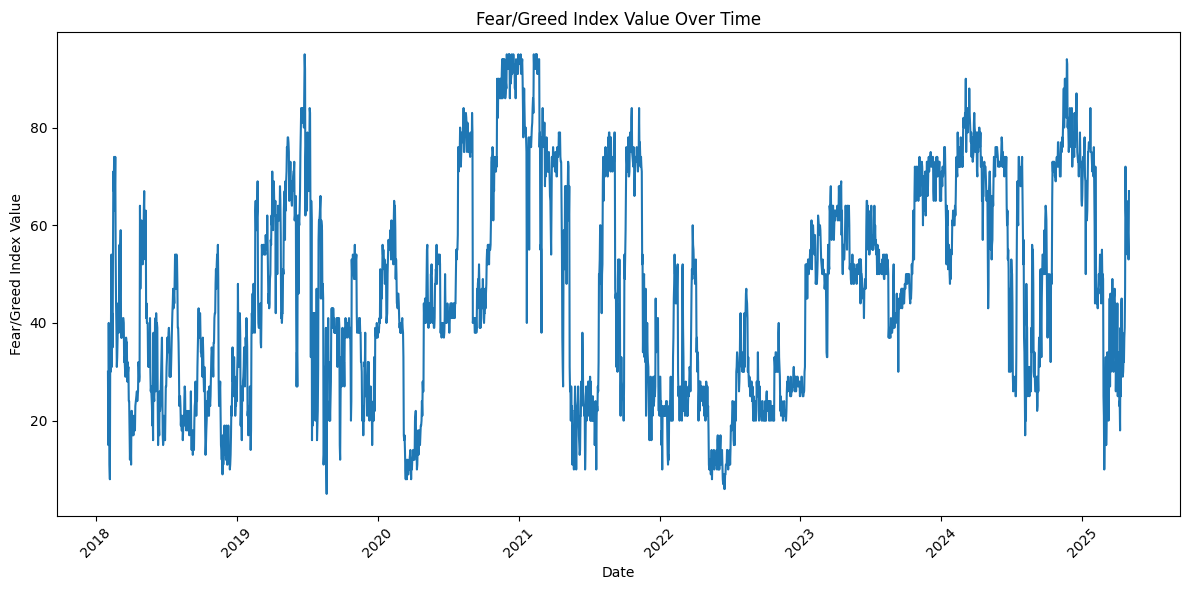

/tmp/ipython-input-1764247582.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='classification', data=sent, order=sent['classification'].value_counts().index, palette='viridis')


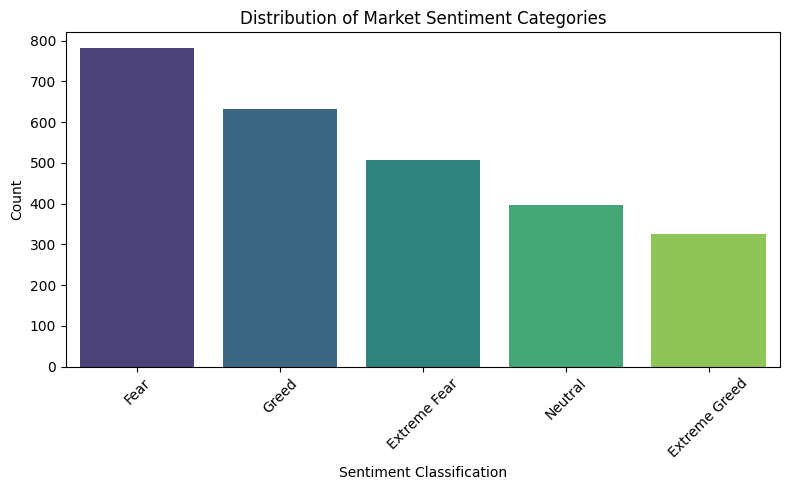

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

if 'sent' in locals() and not sent.empty:
    sent['date'] = pd.to_datetime(sent['date'], errors='coerce').dt.date


    sent_sorted = sent.sort_values('date')


    plt.figure(figsize=(12, 6))
    sns.lineplot(x='date', y='value', data=sent_sorted)
    plt.title('Fear/Greed Index Value Over Time')
    plt.xlabel('Date')
    plt.ylabel('Fear/Greed Index Value')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


    plt.figure(figsize=(8, 5))
    sns.countplot(x='classification', data=sent, order=sent['classification'].value_counts().index, palette='viridis')
    plt.title('Distribution of Market Sentiment Categories')
    plt.xlabel('Sentiment Classification')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("The 'sent' DataFrame is not available or is empty. Cannot generate sentiment plots.")

**Reasoning**:
Generate a time series plot of trade count, a histogram of median trade size, and a histogram of average leverage from the `acct_day` dataframe to visualize trader activity.



Only 1 unique date(s) found in the aggregated data. Time series plot of trade count cannot be generated.
Unique date: 1970-01-01


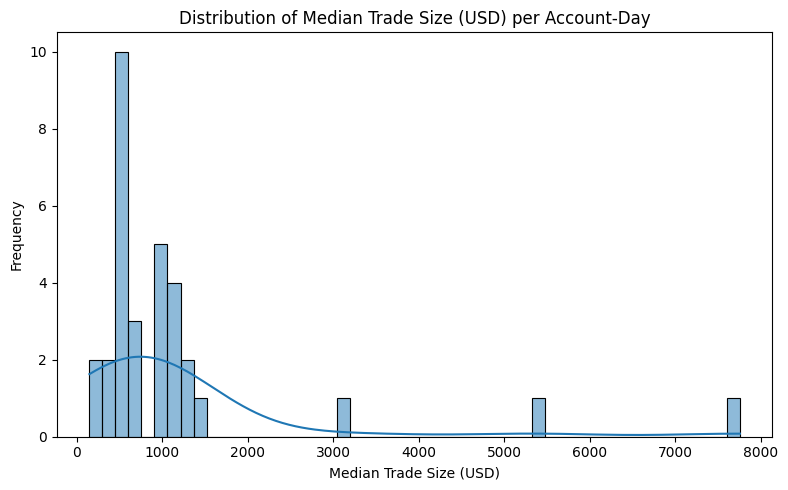

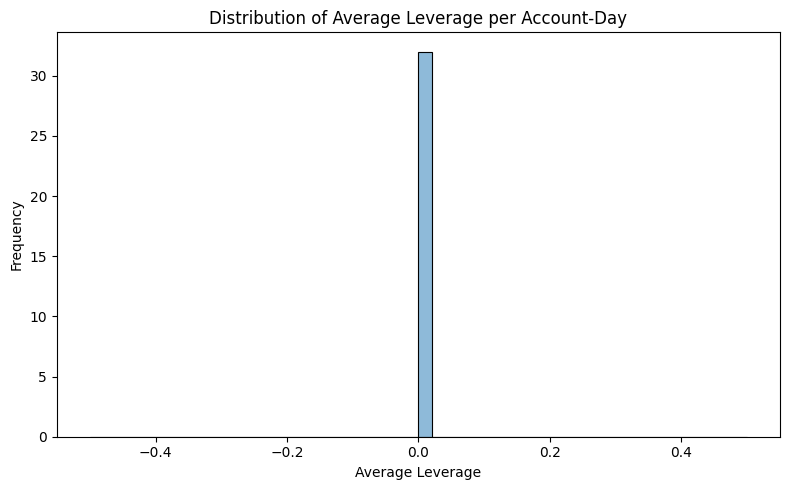

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


if 'acct_day' in locals() and not acct_day.empty:

    acct_day['date'] = pd.to_datetime(acct_day['date'], errors='coerce')
    acct_day_sorted = acct_day.sort_values('date')

    unique_dates = acct_day_sorted['date'].nunique()

    if unique_dates > 1:
        plt.figure(figsize=(12, 6))

        sns.lineplot(x='date', y='trade_count', data=acct_day_sorted, estimator=np.sum, errorbar=None)
        plt.title('Total Trade Count Over Time (Aggregated Daily)')
        plt.xlabel('Date')
        plt.ylabel('Total Trade Count')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
        print(f"Only {unique_dates} unique date(s) found in the aggregated data. Time series plot of trade count cannot be generated.")
        if unique_dates == 1:
            print("Unique date:", acct_day_sorted['date'].iloc[0].date())


    plt.figure(figsize=(8, 5))
    sns.histplot(acct_day['median_size'], bins=50, kde=True)
    plt.title('Distribution of Median Trade Size (USD) per Account-Day')
    plt.xlabel('Median Trade Size (USD)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    avg_leverage_cleaned = acct_day['avg_leverage'].replace([np.inf, -np.inf], np.nan).dropna()
    if not avg_leverage_cleaned.empty:
        plt.figure(figsize=(8, 5))
        sns.histplot(avg_leverage_cleaned, bins=50, kde=True)
        plt.title('Distribution of Average Leverage per Account-Day')
        plt.xlabel('Average Leverage')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()
    else:
        print("Average leverage data is empty or contains only non-finite values after cleaning. Cannot plot histogram.")

else:
    print("The 'acct_day' DataFrame is not available or is empty. Cannot generate trader activity plots.")

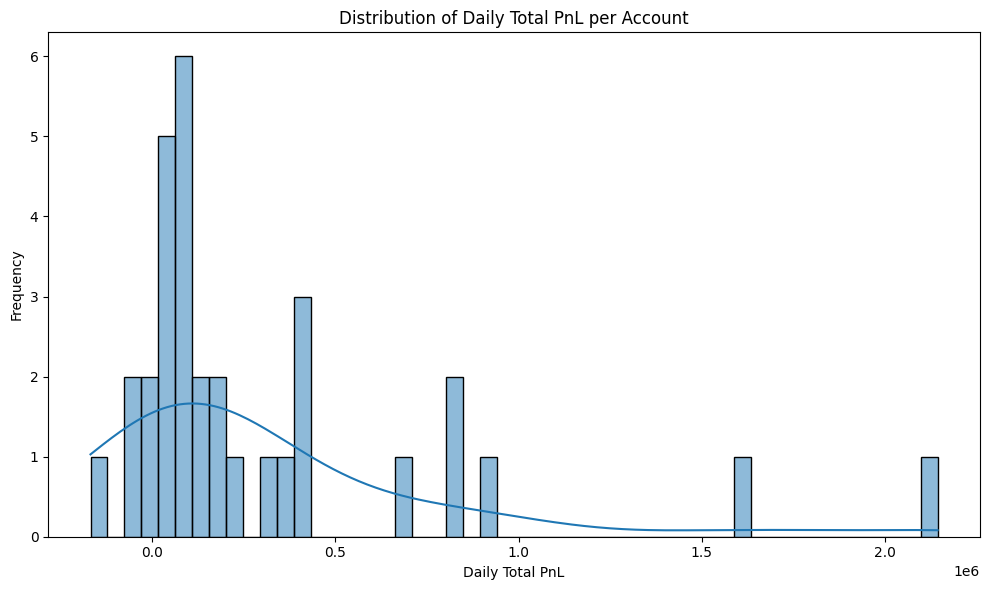

Classification data is not suitable for grouping (all null or only one category). Cannot plot box plot.


In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


if 'merged' in locals() and not merged.empty:


    merged_cleaned_pnl = merged.replace([np.inf, -np.inf], np.nan).dropna(subset=['total_pnl'])

    if not merged_cleaned_pnl.empty:

        plt.figure(figsize=(10, 6))
        sns.histplot(merged_cleaned_pnl['total_pnl'], bins=50, kde=True)
        plt.title('Distribution of Daily Total PnL per Account')
        plt.xlabel('Daily Total PnL')
        plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()
    else:
        print("Total PnL data is empty or contains only non-finite values after cleaning. Cannot plot histogram.")


    if 'classification' in merged.columns and merged['classification'].notna().any() and merged['classification'].nunique() > 1:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='classification', y='total_pnl', data=merged, order=merged['classification'].value_counts().index)
        plt.title('Distribution of Daily Total PnL by Market Sentiment Classification')
        plt.xlabel('Market Sentiment Classification')
        plt.ylabel('Daily Total PnL')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    else:
         print("Classification data is not suitable for grouping (all null or only one category). Cannot plot box plot.")

else:
    print("The 'merged' DataFrame is not available or is empty. Cannot generate trader performance plots.")

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


if 'merged' in locals() and not merged.empty:

    sentiment_grouping_possible = 'classification' in merged.columns and merged['classification'].notna().any() and merged['classification'].nunique() > 1

    if sentiment_grouping_possible:
        plt.figure(figsize=(8, 5))
        sns.barplot(x='classification', y='total_pnl', data=merged, estimator=np.mean, ci=None, order=merged['classification'].value_counts().index)
        plt.title("Average Trader PnL by Market Sentiment")
        plt.xlabel("Market Sentiment")
        plt.ylabel("Average Total PnL")
        plt.xticks(rotation=15)
        plt.tight_layout()
        plt.show()
    else:
        print("Classification data is not suitable for grouping (all null or only one category). Cannot plot average PnL by sentiment.")


    if sentiment_grouping_possible:
        profitable_counts = merged[merged['profitable'] == 1].groupby('classification').size().reset_index(name='profitable_day_count')
        if not profitable_counts.empty:
            plt.figure(figsize=(8, 5))
            sns.barplot(x='classification', y='profitable_day_count', data=profitable_counts, order=merged['classification'].value_counts().index)
            plt.title("Count of Profitable Days by Market Sentiment")
            plt.xlabel("Market Sentiment")
            plt.ylabel("Number of Profitable Days")
            plt.xticks(rotation=15)
            plt.tight_layout()
            plt.show()
        else:
             print("No profitable days found to plot by sentiment classification.")

    else:
        print("Classification data is not suitable for grouping (all null or only one category). Cannot plot profitable day count by sentiment.")


    if sentiment_grouping_possible:
        win_rate_by_sentiment = merged.groupby('classification')['profitable'].mean().reset_index(name='win_rate')
        if not win_rate_by_sentiment.empty:
            plt.figure(figsize=(8, 5))
            sns.barplot(x='classification', y='win_rate', data=win_rate_by_sentiment, order=merged['classification'].value_counts().index)
            plt.title("Win Rate by Market Sentiment")
            plt.xlabel("Market Sentiment")
            plt.ylabel("Win Rate (Proportion of Profitable Days)")
            plt.xticks(rotation=15)
            plt.ylim(0, 1)
            plt.tight_layout()
            plt.show()
        else:
            print("Win rate calculation by sentiment classification resulted in empty data. Cannot plot win rate.")
    else:
        print("Classification data is not suitable for grouping (all null or only one category). Cannot plot win rate by sentiment.")



    merged_cleaned_scatter = merged.replace([np.inf, -np.inf], np.nan).dropna(subset=['avg_leverage', 'total_pnl'])

    if not merged_cleaned_scatter.empty:

        if sentiment_grouping_possible:
             plt.figure(figsize=(10, 6))
             sns.scatterplot(x='avg_leverage', y='total_pnl', hue='classification', data=merged_cleaned_scatter, palette='viridis')
             plt.title("Average Leverage vs. Total PnL by Market Sentiment")
             plt.xlabel("Average Leverage")
             plt.ylabel("Total PnL")
             plt.tight_layout()
             plt.show()
        else:
             print("Classification data is not suitable for hue (all null or only one category). Cannot color scatter plot by sentiment.")
    else:
        print("Average leverage or total PnL data is empty or contains only non-finite values after cleaning for scatter plot. Cannot generate scatter plot.")

else:
    print("The 'merged' DataFrame is not available or is empty. Cannot generate sentiment vs performance plots.")

Classification data is not suitable for grouping (all null or only one category). Cannot plot average PnL by sentiment.
Classification data is not suitable for grouping (all null or only one category). Cannot plot profitable day count by sentiment.
Classification data is not suitable for grouping (all null or only one category). Cannot plot win rate by sentiment.
Classification data is not suitable for hue (all null or only one category). Cannot color scatter plot by sentiment.


Data for correlation heatmap is empty after handling missing values. Cannot generate heatmap.
Classification data is not suitable for hue (all null or only one category). Scatter plot not colored by sentiment.


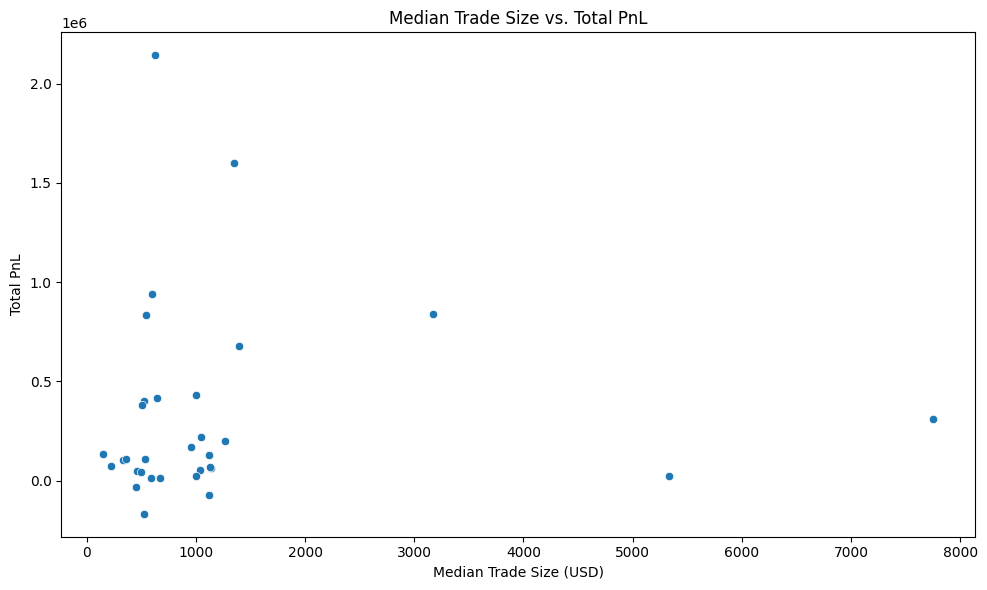

Classification data is not suitable for hue (all null or only one category). Scatter plot not colored by sentiment.


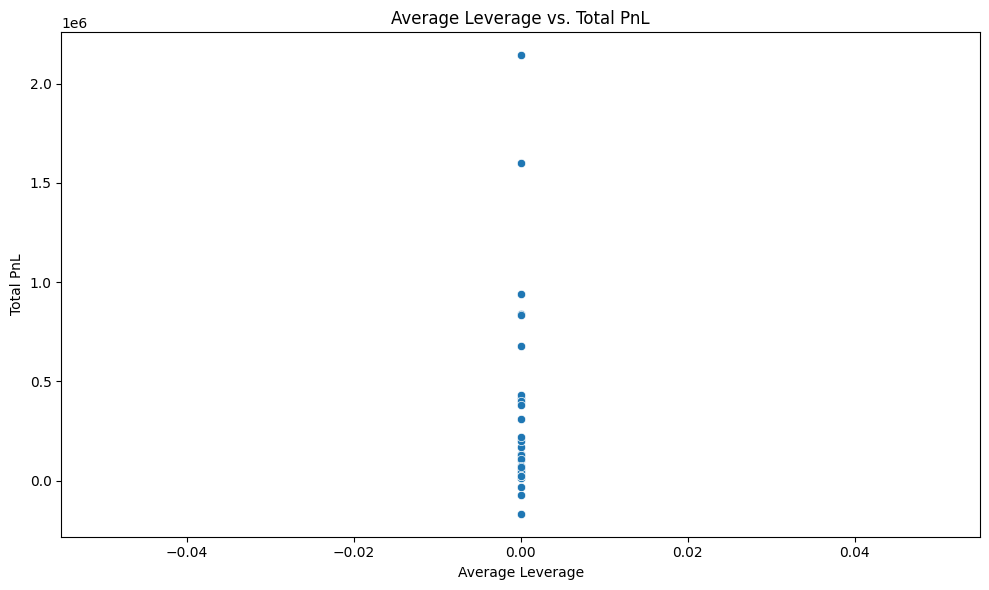

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


if 'merged' in locals() and not merged.empty:


    correlation_cols = ['total_pnl', 'median_size', 'avg_leverage', 'value', 'sentiment_code']


    if all(col in merged.columns for col in correlation_cols):
        merged_cleaned_corr = merged[correlation_cols].replace([np.inf, -np.inf], np.nan).dropna()

        if not merged_cleaned_corr.empty:
            correlation_matrix = merged_cleaned_corr.corr()

            plt.figure(figsize=(10, 8))
            sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
            plt.title("Correlation Matrix of Trader Metrics and Sentiment")
            plt.tight_layout()
            plt.show()
        else:
            print("Data for correlation heatmap is empty after handling missing values. Cannot generate heatmap.")
    else:
        print("Required columns for correlation heatmap are missing in the 'merged' DataFrame.")


    sentiment_grouping_possible = 'classification' in merged.columns and merged['classification'].notna().any() and merged['classification'].nunique() > 1


    scatter_cols_pnl_size = ['median_size', 'total_pnl', 'classification']
    if all(col in merged.columns for col in scatter_cols_pnl_size):

        merged_cleaned_scatter_pnl_size = merged[scatter_cols_pnl_size].replace([np.inf, -np.inf], np.nan).dropna(subset=['median_size', 'total_pnl'])

        if not merged_cleaned_scatter_pnl_size.empty:
            plt.figure(figsize=(10, 6))
            if sentiment_grouping_possible:
                 sns.scatterplot(x='median_size', y='total_pnl', hue='classification', data=merged_cleaned_scatter_pnl_size, palette='viridis')
                 plt.title("Median Trade Size vs. Total PnL by Market Sentiment")
                 plt.xlabel("Median Trade Size (USD)")
                 plt.ylabel("Total PnL")
            else:
                 sns.scatterplot(x='median_size', y='total_pnl', data=merged_cleaned_scatter_pnl_size)
                 plt.title("Median Trade Size vs. Total PnL")
                 plt.xlabel("Median Trade Size (USD)")
                 plt.ylabel("Total PnL")
                 print("Classification data is not suitable for hue (all null or only one category). Scatter plot not colored by sentiment.")
            plt.tight_layout()
            plt.show()
        else:
            print("Median size or total PnL data is empty or contains only non-finite values after cleaning for scatter plot. Cannot generate scatter plot.")
    else:
        print("Required columns for median_size vs total_pnl scatter plot are missing in the 'merged' DataFrame.")



    scatter_cols_pnl_leverage = ['avg_leverage', 'total_pnl', 'classification']
    if all(col in merged.columns for col in scatter_cols_pnl_leverage):

        merged_cleaned_scatter_pnl_leverage = merged[scatter_cols_pnl_leverage].replace([np.inf, -np.inf], np.nan).dropna(subset=['avg_leverage', 'total_pnl'])

        if not merged_cleaned_scatter_pnl_leverage.empty:
            plt.figure(figsize=(10, 6))
            if sentiment_grouping_possible:
                sns.scatterplot(x='avg_leverage', y='total_pnl', hue='classification', data=merged_cleaned_scatter_pnl_leverage, palette='viridis')
                plt.title("Average Leverage vs. Total PnL by Market Sentiment")
                plt.xlabel("Average Leverage")
                plt.ylabel("Total PnL")
            else:
                sns.scatterplot(x='avg_leverage', y='total_pnl', data=merged_cleaned_scatter_pnl_leverage)
                plt.title("Average Leverage vs. Total PnL")
                plt.xlabel("Average Leverage")
                plt.ylabel("Total PnL")
                print("Classification data is not suitable for hue (all null or only one category). Scatter plot not colored by sentiment.")

            plt.tight_layout()
            plt.show()
        else:
            print("Average leverage or total PnL data is empty or contains only non-finite values after cleaning for scatter plot. Cannot generate scatter plot.")
    else:
         print("Required columns for avg_leverage vs total_pnl scatter plot are missing in the 'merged' DataFrame.")


else:
    print("The 'merged' DataFrame is not available or is empty. Cannot generate correlation and scatter plots.")

In [25]:

if 'merged_cleaned_corr' in locals():
  print("Info of merged_cleaned_corr:")
  display(merged_cleaned_corr.info())
  print("\nHead of merged_cleaned_corr:")
  display(merged_cleaned_corr.head())
  print("\nMissing values in merged_cleaned_corr:")
  display(merged_cleaned_corr.isnull().sum())
  print("\nUnique values in merged_cleaned_corr 'avg_leverage':")
  display(merged_cleaned_corr['avg_leverage'].nunique())
  print("\nUnique values in merged_cleaned_corr 'value':")
  display(merged_cleaned_corr['value'].nunique())
  print("\nUnique values in merged_cleaned_corr 'sentiment_code':")
  display(merged_cleaned_corr['sentiment_code'].nunique())

else:
  print("'merged_cleaned_corr' DataFrame not found. Please run the cell that generates it first.")

Info of merged_cleaned_corr:
<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_pnl       0 non-null      float64
 1   median_size     0 non-null      float64
 2   avg_leverage    0 non-null      float64
 3   value           0 non-null      float64
 4   sentiment_code  0 non-null      float64
dtypes: float64(5)
memory usage: 0.0 bytes


None


Head of merged_cleaned_corr:


,total_pnl,median_size,avg_leverage,value,sentiment_code



Missing values in merged_cleaned_corr:


,0
total_pnl,0
median_size,0
avg_leverage,0
value,0
sentiment_code,0



Unique values in merged_cleaned_corr 'avg_leverage':


0


Unique values in merged_cleaned_corr 'value':


0


Unique values in merged_cleaned_corr 'sentiment_code':


0